In [1]:
# Importing the necessary libraries
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import pickle



## Visualization and Data Collection

In [37]:
dataset = pd.read_csv("garments_worker_productivity.csv")
dataset.head

<bound method NDFrame.head of            date   quarter  department        day  team  targeted_productivity  \
0      1/1/2015  Quarter1      sweing   Thursday     8                   0.80   
1      1/1/2015  Quarter1  finishing    Thursday     1                   0.75   
2      1/1/2015  Quarter1      sweing   Thursday    11                   0.80   
3      1/1/2015  Quarter1      sweing   Thursday    12                   0.80   
4      1/1/2015  Quarter1      sweing   Thursday     6                   0.80   
...         ...       ...         ...        ...   ...                    ...   
1192  3/11/2015  Quarter2   finishing  Wednesday    10                   0.75   
1193  3/11/2015  Quarter2   finishing  Wednesday     8                   0.70   
1194  3/11/2015  Quarter2   finishing  Wednesday     7                   0.65   
1195  3/11/2015  Quarter2   finishing  Wednesday     9                   0.75   
1196  3/11/2015  Quarter2   finishing  Wednesday     6                   0.70  

## Data Preprocessing

### Checking the Null Value

In [38]:
print("Data Shape is:",dataset.shape)
dataset.info()

Data Shape is: (1197, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 no

In [39]:
dataset.drop(['wip'],axis =1,inplace= True)

In [40]:
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['month'] = dataset['date'].dt.month
dataset.drop(['date'], axis = 1, inplace= True)

In [41]:
dataset["department"].value_counts()

department
sweing        691
finishing     257
finishing     249
Name: count, dtype: int64

In [42]:
dataset["department"] = dataset["department"].apply(lambda x: "finishing" if x.replace(" ","") == "finishing" else "sweing" )
dataset["department"].value_counts()

department
sweing       691
finishing    506
Name: count, dtype: int64

In [43]:
dataset["month"].value_counts()

month
1    542
2    443
3    212
Name: count, dtype: int64

In [44]:
dataset.describe()

,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091,1.724311
std,3.463963,0.097891,10.943219,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488,0.744558
min,1.000000,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705,1.000000
25%,3.000000,0.700000,3.940000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307,1.000000
50%,6.000000,0.750000,15.260000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333,2.000000
75%,9.000000,0.800000,24.260000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253,2.000000
max,12.000000,0.800000,54.560000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437,3.000000


In [45]:
dataset.sample(5)

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month
967,Quarter4,sweing,Saturday,12,0.80,15.26,1700,62,0.0,0,0,34.0,0.800261,2
771,Quarter3,finishing,Sunday,5,0.75,4.15,240,0,0.0,0,0,2.0,0.760833,2
89,Quarter1,sweing,Tuesday,9,0.80,26.16,10620,75,0.0,0,0,59.0,0.850502,1
691,Quarter2,finishing,Monday,12,0.80,4.08,1080,0,0.0,0,0,9.0,0.272000,2
471,Quarter4,sweing,Tuesday,12,0.70,15.26,4080,40,0.0,0,0,34.0,0.700165,1


In [46]:
unique_values = dataset.nunique()
print(unique_values)

quarter                    5
department                 2
day                        6
team                      12
targeted_productivity      9
smv                       70
over_time                143
incentive                 48
idle_time                 12
idle_men                  10
no_of_style_change         3
no_of_workers             61
actual_productivity      879
month                      3
dtype: int64


In [47]:
dataset["department"]=dataset["department"].str.strip().str.lower()
dataset["quarter"] =dataset["quarter"].str.strip().str.lower()
dataset["day"]=dataset["day"].str.strip().str.lower()

In [48]:
dataset.sample(5)

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month
64,quarter1,finishing,monday,3,0.75,4.15,1920,0,0.0,0,0,8.0,0.875391,1
1098,quarter1,finishing,saturday,1,0.70,3.94,960,0,0.0,0,0,8.0,0.664875,3
429,quarter4,sweing,sunday,7,0.70,22.52,10170,40,0.0,0,0,56.5,0.700542,1
371,quarter4,finishing,thursday,7,0.60,3.94,6000,0,0.0,0,0,10.0,0.957639,1
582,quarter1,sweing,tuesday,10,0.80,22.52,6720,90,0.0,0,0,56.0,0.999995,2


In [49]:
from multicolumn_label_encoder import MultiColumnLabelEncoder
encoder = MultiColumnLabelEncoder(columns=['quarter','department','team','day','no_of_style_change','month'])
data_ev = encoder.fit_transform(dataset)
data_ev.sample(5)

,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,month
783,2,0,2,6,0.75,4.15,2400,0,0.0,0,0,20.0,0.287042,1
179,1,0,2,4,0.80,3.94,1440,0,0.0,0,0,8.0,0.820833,0
954,3,1,3,4,0.70,30.33,6960,0,0.0,0,1,58.0,0.662379,1
1188,1,1,5,7,0.70,26.82,6960,30,0.0,0,1,58.0,0.700557,2
980,3,1,1,6,0.50,26.66,6960,23,0.0,0,2,58.0,0.500258,1


### ? Again checking the corr

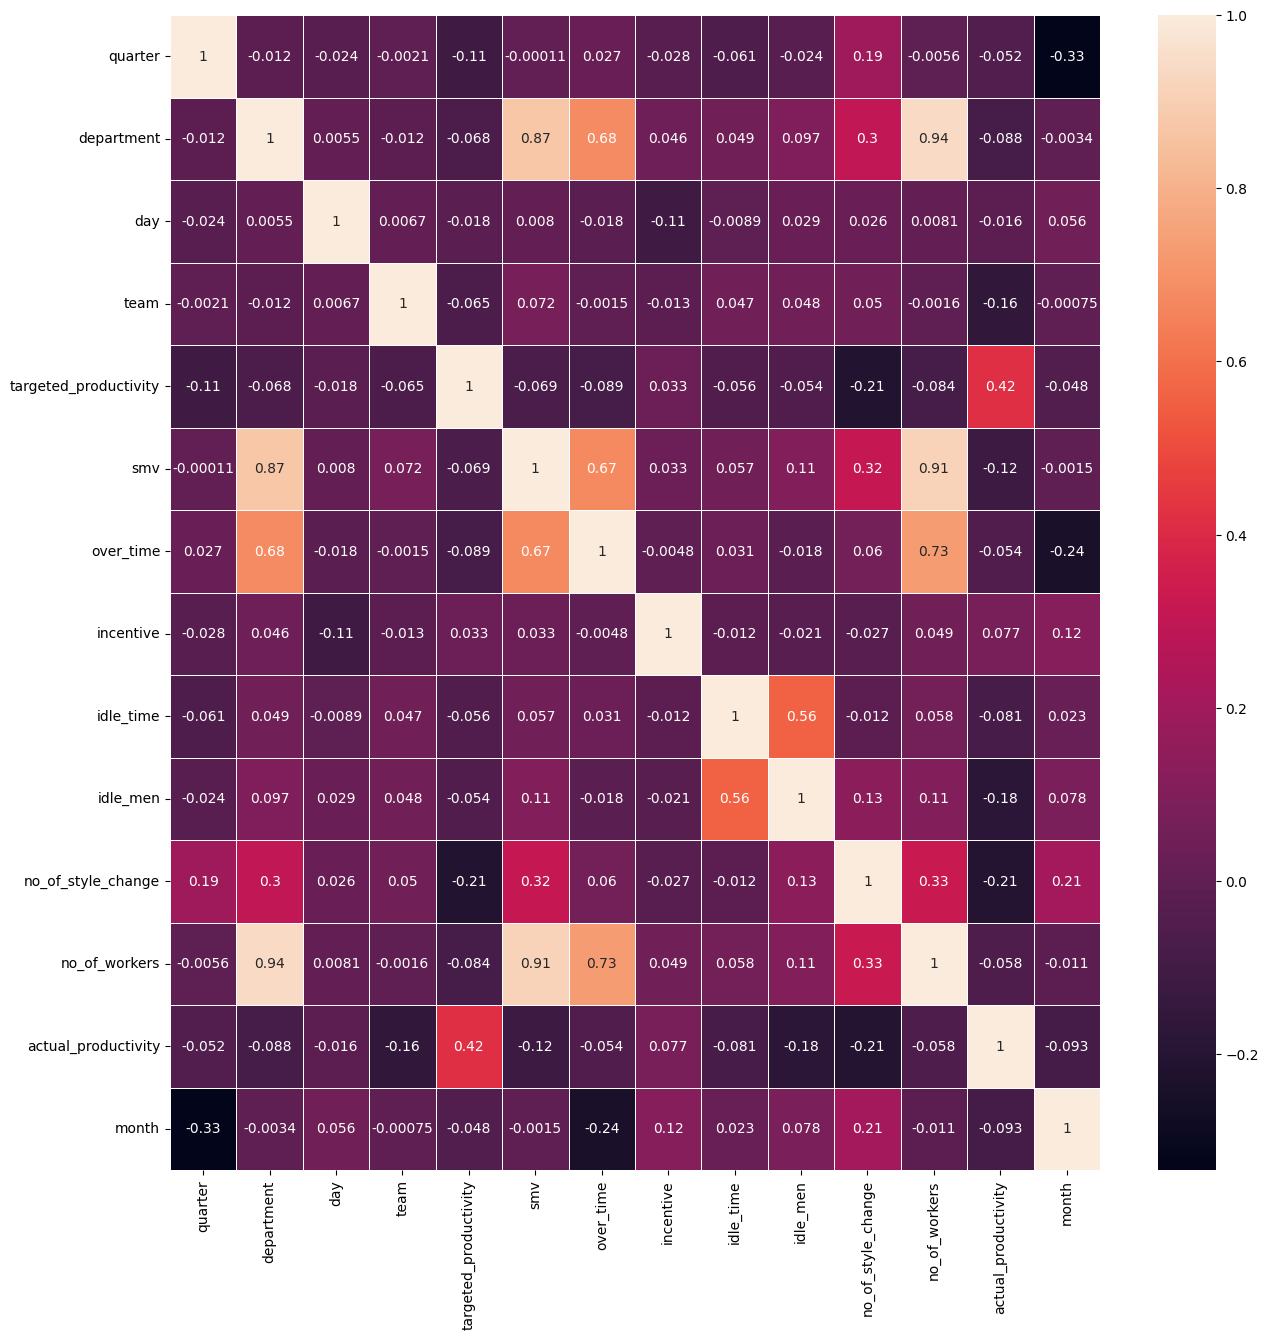

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Corrected function name: use plt.subplots() instead of plt.subplot()
corrMatrix = data_ev.corr()
fig, ax = plt.subplots(figsize=(15, 15))  

# Ensure corrMatrix is defined before using it
sns.heatmap(corrMatrix, annot=True, linewidths=0.5, ax=ax)

plt.show()


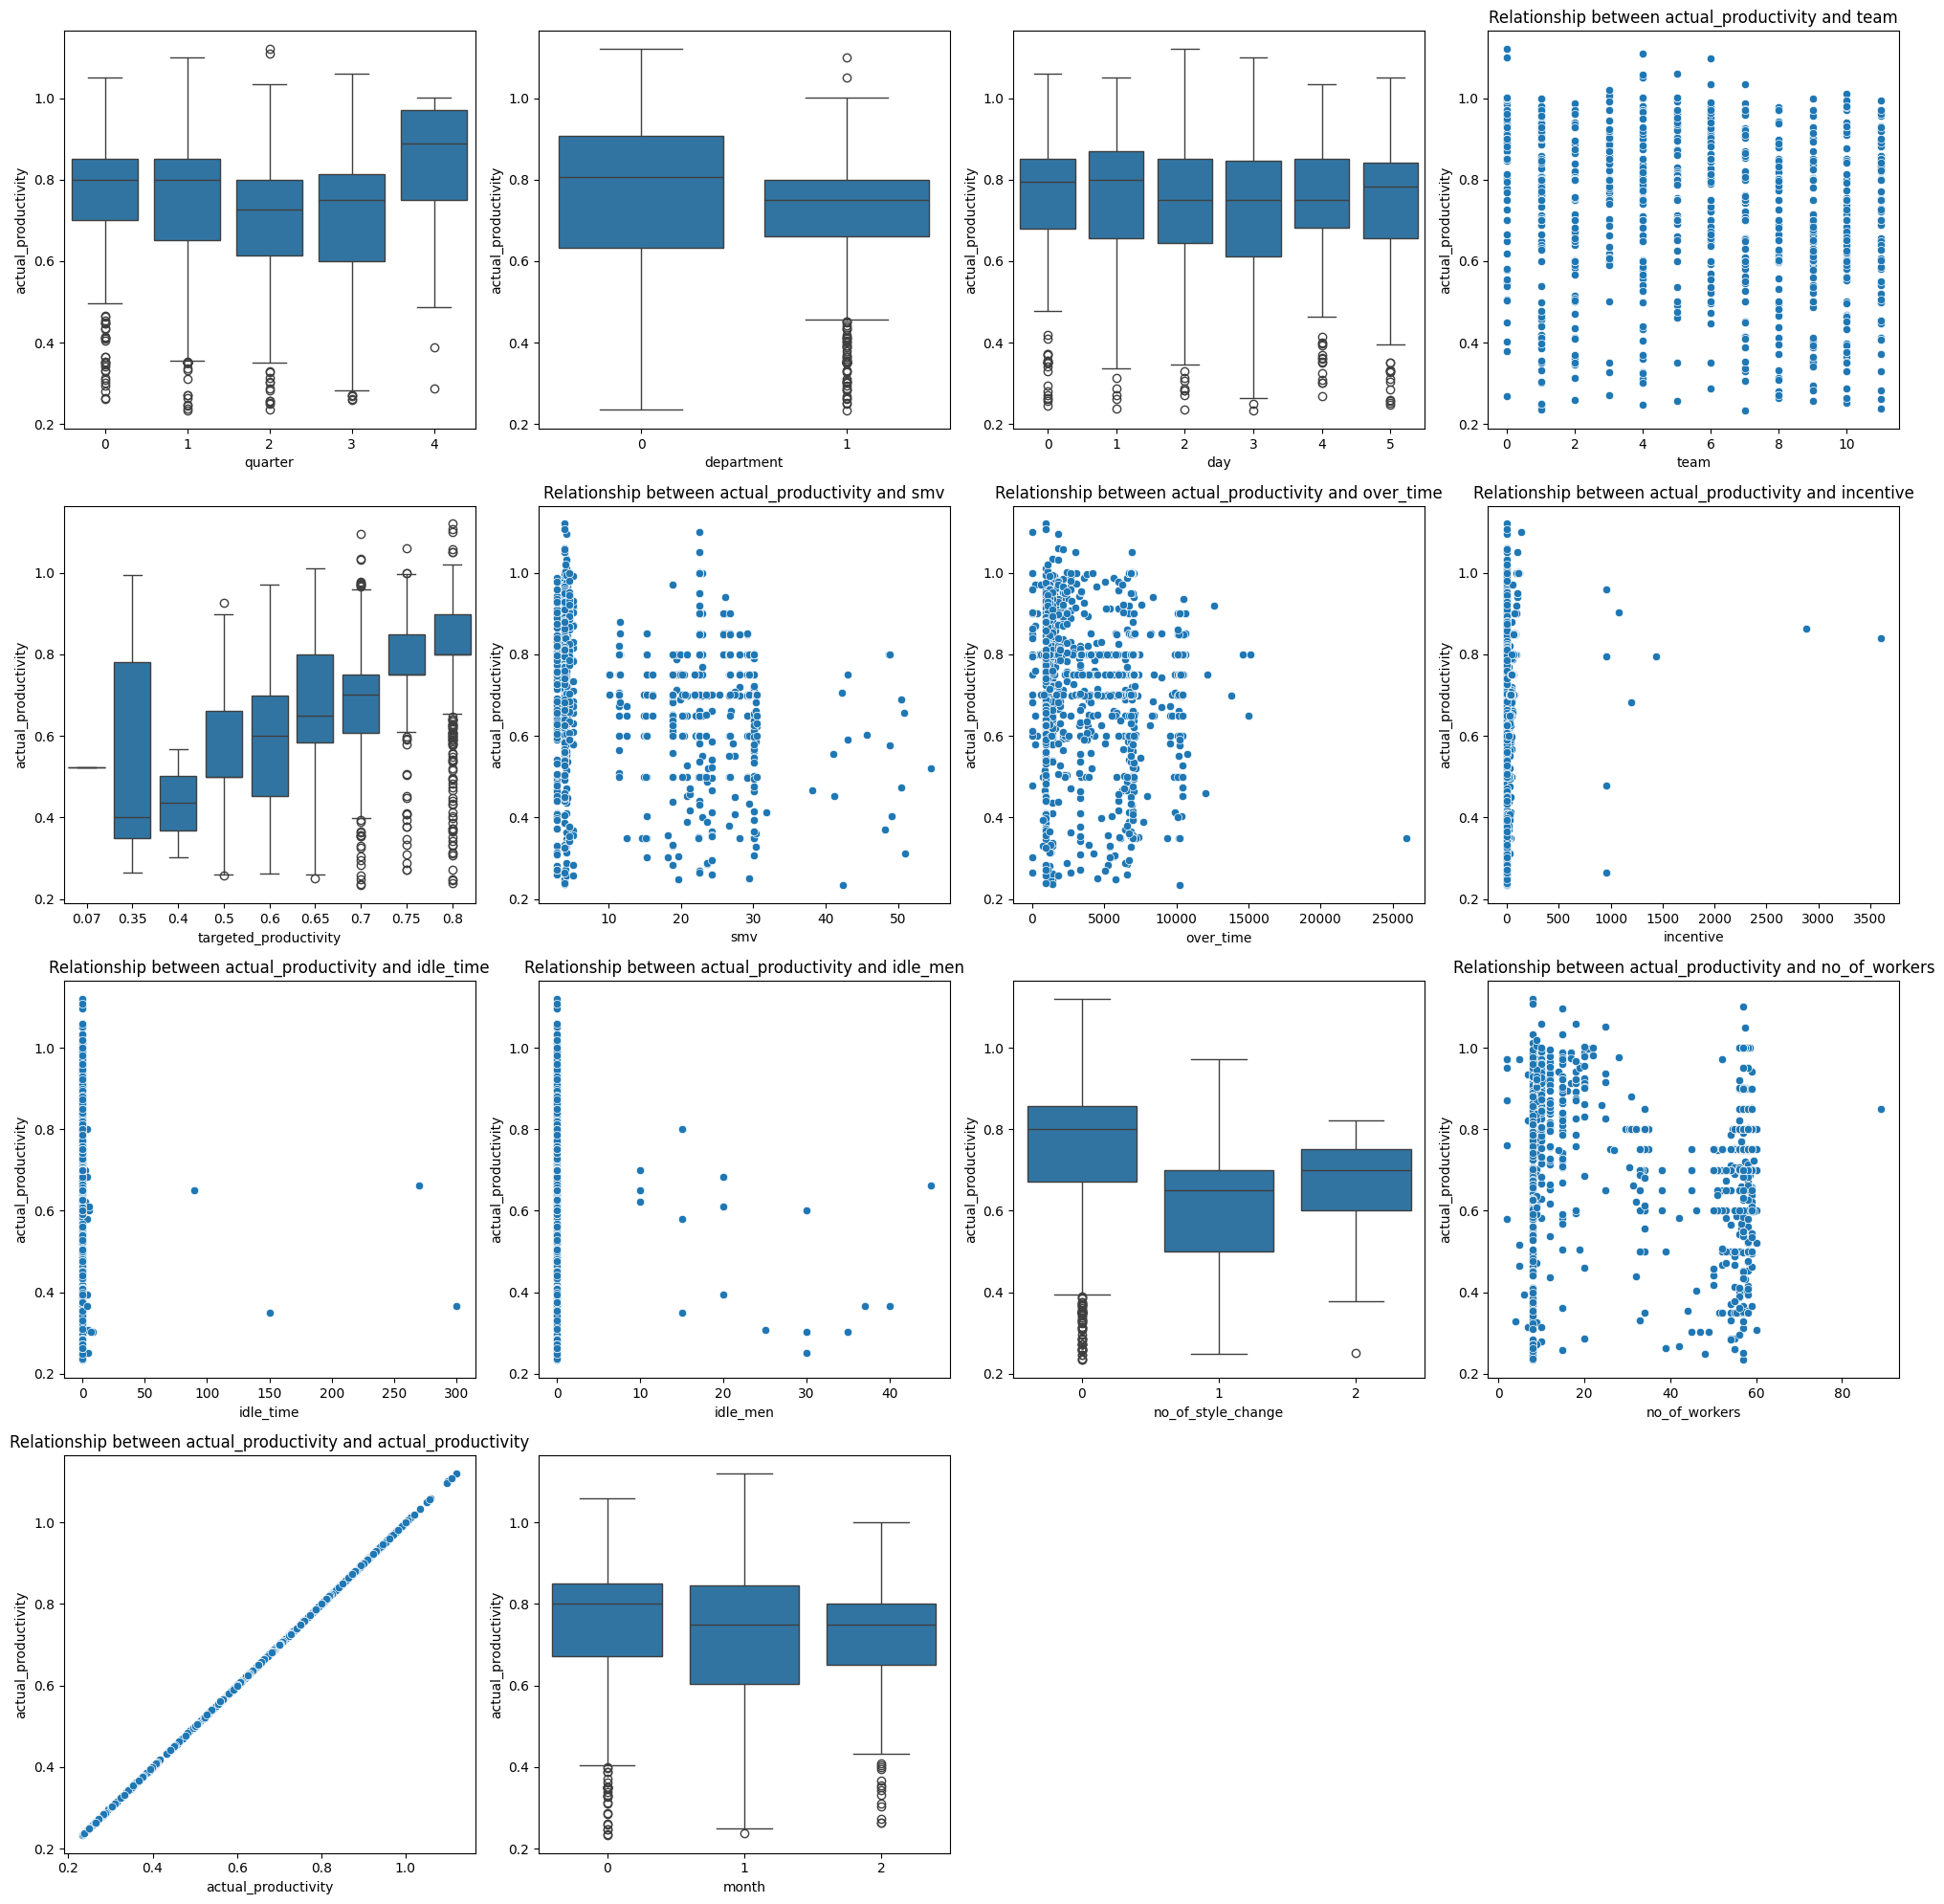

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
columns = [ "quarter" ,	"department", "day","team",	"targeted_productivity",
           "smv",	"over_time","incentive",	"idle_time","idle_men", "no_of_style_change",
           "no_of_workers",	"actual_productivity",	"month"]
plt.figure(figsize =(20,20))
for i, columns in enumerate(columns,1):
    plt.subplot(4,4,i)
    if data_ev [columns].dtype == "object" or data_ev[columns].nunique()<10:
        sns.boxplot(x=data_ev[columns],y=data_ev["actual_productivity"])
    else:
        sns.scatterplot(x=data_ev[columns],y=data_ev["actual_productivity"])
        plt.title(f"Relationship between actual_productivity and {columns}")
        plt.xlabel(columns)
        plt.ylabel("actual_productivity")

plt.tight_layout()
plt.show()

In [52]:
data_ev.corr()['actual_productivity']

quarter                 -0.051970
department              -0.087624
day                     -0.015690
team                    -0.157049
targeted_productivity    0.421594
smv                     -0.122089
over_time               -0.054206
incentive                0.076538
idle_time               -0.080851
idle_men                -0.181734
no_of_style_change      -0.207366
no_of_workers           -0.057991
actual_productivity      1.000000
month                   -0.092914
Name: actual_productivity, dtype: float64

In [53]:
x=data_ev.drop(["actual_productivity"],axis=1)
y=data_ev['actual_productivity']

### Spliting Data into Train and Test 

In [54]:
x=data_ev.drop(["actual_productivity"],axis=1)
y=data_ev['actual_productivity']


In [55]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test =  train_test_split(x,y,train_size=0.8,random_state=0)


### Model Building

#### Linear Regression Model

In [56]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()


In [57]:
model_lr.fit(x_train,y_train)

LinearRegression()

In [58]:
pred_test = model_lr.predict(x_test)
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
# Evaluate the model
print("test_MSE:", mean_squared_error(y_test, pred_test))
print("test_MAE:", mean_absolute_error(y_test, pred_test))
print("R2_Score:",(r2_score(y_test, pred_test)))

test_MSE: 0.021507203121475627
test_MAE: 0.10727112243966742
R2_Score: 0.27256608178024544


### Random Forest

In [59]:
from sklearn.ensemble import RandomForestRegressor
model_rf =  RandomForestRegressor(n_estimators=200,max_depth=5)

In [60]:
model_rf.fit(x_train,y_train)

RandomForestRegressor(max_depth=5, n_estimators=200)

In [61]:
pred_test = model_rf.predict(x_test)
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
# Evaluate the model
print("test_MSE:", mean_squared_error(y_test, pred_test))
print("test_MAE:", mean_absolute_error(y_test, pred_test))
print("R2_Score:",(r2_score(y_test, pred_test)))

test_MSE: 0.016218777371983233
test_MAE: 0.08717979371812717
R2_Score: 0.4514354699772706


### Xgboost Model

In [63]:
model_xgb =  xgb.XGBRegressor(n_estimators=200,max_depth=5,learning_rate=0.1)
model_xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [64]:
pred3 = model_xgb.predict(x_test)
print("test_MSE:", mean_squared_error(y_test, pred_test))
print("test_MAE:", mean_absolute_error(y_test, pred_test))
print("R2_Score:{}".format(r2_score(y_test, pred_test)))

test_MSE: 0.016218777371983233
test_MAE: 0.08717979371812717
R2_Score:0.4514354699772706


### Compare Model 

In [65]:
import pickle

pickle.dump(model_xgb,open("model.pkl","wb"))
pickle.dump(encoder,open("mcle.pkl","wb"))

In [66]:
model_xgb = pickle.load(open('model.pkl','rb'))
mcle = pickle.load(open('mcle.pkl','rb'))
data = pd.read_csv('garments_worker_productivity.csv')
data.drop(['wip'],axis=1,inplace=True)
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data.drop(['date'],axis=1,inplace=True)
data.drop(['actual_productivity'],axis=1,inplace=True)
data['department']=data['department'].apply(lambda x:'finishing' if x.replace(" ","") == 'finishing' else 'sweing' )
data[0:1]


,quarter,department,day,team,targeted_productivity,smv,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,month
0,Quarter1,sweing,Thursday,8,0.8,26.16,7080,98,0.0,0,0,59.0,1


In [67]:
example_data = { 'quarter':['Quarter1'.lower()],
                'department':['sweing'.lower()],
                'day':['Thursday'.lower()],
                'team':[1],
                'targeted_productivity':[0.80],
                'smv':[0.16],
                'over_time':[0],
                'incentive':[0],
                'idle_time':[0],
                'idle_men':[0],
                'no_of_style_change':[0],
                'no_of_workers':[0],
                'month':[3]
}
example_df = pd.DataFrame(example_data)
example_encoded= mcle.transform(example_df)
example_array = example_encoded.to_numpy()
predicted_productivity_example = model_xgb.predict(example_array)
print("Predicted Productivity for example  data :",predicted_productivity_example)

Predicted Productivity for example  data : [0.7783586]


In [68]:
data['no_of_style_change'].value_counts()

no_of_style_change
0    1050
1     114
2      33
Name: count, dtype: int64